In [1]:
# https://www.kaggle.com/kutaykutlu/resnet50-transfer-learning-cifar-10-beginner

# https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

In [2]:
from keras.applications.vgg16 import VGG16
from tensorflow import keras

In [3]:
model = VGG16(weights='imagenet')

In [4]:
import tensorflow as tf
import numpy as np
import pathlib

# step 1
# IMAGE_PATHS_DIR =
IMAGE_PATHS_DIR =
# IMAGE_PATHS_DIR = 

paths = np.array([x.__str__() for x in pathlib.Path(IMAGE_PATHS_DIR).rglob('*.bmp')])
filenames = tf.constant(paths)

labels_array = np.array([x.split("\\")[-1].split("_")[0] for x in paths])
labels = tf.constant(labels_array)

n_clases = np.max([int(i) for i in labels_array])

# step 2: create a dataset returning slices of `filenames`
dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

dataset_len = len(dataset)

train_size = int(0.7 * dataset_len)
test_size = int(0.30 * dataset_len)

def _parse_function(filename, label):
    img = tf.io.read_file(filename)
    image = tf.image.decode_bmp(img, channels = 3)
    label = int(label)
    return image, label

dataset = dataset.shuffle(dataset_len, seed=42)
dataset = dataset.map(_parse_function)

train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size)

size = (224, 224)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))


def label_preprocess(image, label):
    label = tf.one_hot(label-1, n_clases) 
    return image, label

train_ds = train_ds.map(
    label_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)

batch_size = 64

train_ds = train_ds.batch(batch_size=batch_size, drop_remainder=True)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(label_preprocess)
test_ds = test_ds.batch(batch_size=batch_size, drop_remainder=True)

In [5]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))

outputs = VGG16(include_top=True, weights=None, classes=n_clases)(inputs)
model = keras.Model(inputs, outputs)

model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

In [6]:
epochs = 5  # @param {type: "slider", min:10, max:100}
hist = model.fit(train_ds, epochs=epochs, validation_data=test_ds, verbose=2)

Epoch 1/5
12/12 - 420s - loss: 138.1001 - accuracy: 0.0026 - val_loss: 4.6769 - val_accuracy: 0.0125 - 420s/epoch - 35s/step
Epoch 2/5
12/12 - 393s - loss: 4.6903 - accuracy: 0.0091 - val_loss: 4.6830 - val_accuracy: 0.0063 - 393s/epoch - 33s/step
Epoch 3/5
12/12 - 417s - loss: 4.6826 - accuracy: 0.0104 - val_loss: 4.6803 - val_accuracy: 0.0094 - 417s/epoch - 35s/step
Epoch 4/5
12/12 - 417s - loss: 4.6830 - accuracy: 0.0104 - val_loss: 4.6801 - val_accuracy: 0.0094 - 417s/epoch - 35s/step
Epoch 5/5
12/12 - 418s - loss: 4.6843 - accuracy: 0.0117 - val_loss: 4.6813 - val_accuracy: 0.0188 - 418s/epoch - 35s/step


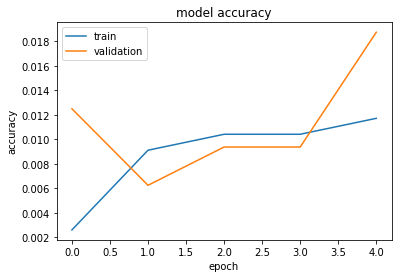

In [7]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [9]:
from tensorflow.keras import layers


def build_model(num_classes):
    inputs = layers.Input(shape=(224, 224, 3))
    x = img_augmentation(inputs)
    model = VGG16(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs)
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [10]:
model = build_model(num_classes=n_clases)

epochs = 10  # @param {type: "slider", min:8, max:80}
hist = model.fit(train_ds, epochs=epochs, validation_data=test_ds, verbose=2)

Epoch 1/10
12/12 - 133s - loss: 4.5488 - accuracy: 0.1276 - val_loss: 6.9878 - val_accuracy: 0.1000 - 133s/epoch - 11s/step
Epoch 2/10
12/12 - 135s - loss: 1.8056 - accuracy: 0.6224 - val_loss: 4.6363 - val_accuracy: 0.2656 - 135s/epoch - 11s/step
Epoch 3/10
12/12 - 138s - loss: 0.8710 - accuracy: 0.7995 - val_loss: 3.6013 - val_accuracy: 0.2594 - 138s/epoch - 11s/step
Epoch 4/10
12/12 - 143s - loss: 0.5479 - accuracy: 0.8919 - val_loss: 1.8796 - val_accuracy: 0.5531 - 143s/epoch - 12s/step
Epoch 5/10
12/12 - 139s - loss: 0.2770 - accuracy: 0.9479 - val_loss: 1.1204 - val_accuracy: 0.7063 - 139s/epoch - 12s/step
Epoch 6/10
12/12 - 136s - loss: 0.1925 - accuracy: 0.9635 - val_loss: 0.7048 - val_accuracy: 0.8344 - 136s/epoch - 11s/step
Epoch 7/10
12/12 - 137s - loss: 0.1498 - accuracy: 0.9701 - val_loss: 0.4805 - val_accuracy: 0.8719 - 137s/epoch - 11s/step
Epoch 8/10
12/12 - 136s - loss: 0.1313 - accuracy: 0.9818 - val_loss: 0.2886 - val_accuracy: 0.9281 - 136s/epoch - 11s/step
Epoch 9/

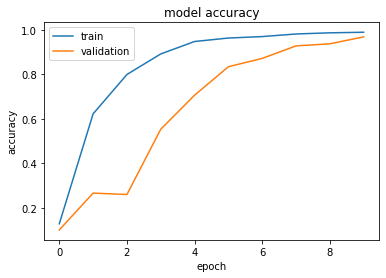

In [11]:
plot_hist(hist)

Epoch 1/5
12/12 - 338s - loss: 1.1934 - accuracy: 0.6992 - val_loss: 8.3528 - val_accuracy: 0.2500 - 338s/epoch - 28s/step
Epoch 2/5
12/12 - 350s - loss: 0.7412 - accuracy: 0.8073 - val_loss: 5.0176 - val_accuracy: 0.3750 - 350s/epoch - 29s/step
Epoch 3/5
12/12 - 352s - loss: 0.4149 - accuracy: 0.8958 - val_loss: 3.4885 - val_accuracy: 0.4719 - 352s/epoch - 29s/step
Epoch 4/5
12/12 - 350s - loss: 0.2337 - accuracy: 0.9440 - val_loss: 1.8178 - val_accuracy: 0.6125 - 350s/epoch - 29s/step
Epoch 5/5
12/12 - 341s - loss: 0.1649 - accuracy: 0.9583 - val_loss: 0.8594 - val_accuracy: 0.7625 - 341s/epoch - 28s/step


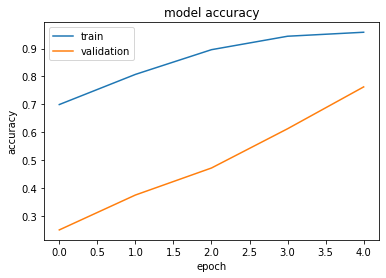

In [12]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 5  # @param {type: "slider", min:8, max:50}
hist = model.fit(train_ds, epochs=epochs, validation_data=test_ds, verbose=2)
plot_hist(hist)

In [29]:
size = (224, 224)

def _parse_image(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_bmp(img, channels = 3)
    img = tf.image.resize(img, size)
    img = tf.expand_dims(img, 0)
    return img

# try_image_path =  
try_image_path =  

try_image = _parse_image(try_image_path)

In [30]:
result = model.predict(try_image)
np.argmax(result) +1

51

In [27]:
result

array([[1.87577176e-09, 9.99983072e-01, 1.43423183e-13, 4.51463389e-12,
        9.66088276e-09, 2.71160785e-11, 1.11797860e-09, 9.10770001e-11,
        8.74848284e-12, 2.16770668e-09, 1.83411231e-10, 2.20195186e-13,
        3.26352945e-09, 1.25531008e-08, 2.46699727e-08, 3.31117057e-12,
        2.54939209e-06, 1.37348097e-12, 1.61500171e-11, 2.02542978e-08,
        2.22832135e-08, 2.55434944e-08, 7.38563516e-11, 2.48019716e-09,
        1.47036949e-11, 2.12098585e-11, 2.17068745e-07, 3.16465409e-09,
        6.01794439e-13, 4.94443505e-12, 4.01616899e-06, 7.36863441e-08,
        4.83530091e-11, 1.24407391e-08, 2.93633207e-09, 7.15121462e-10,
        8.96994035e-10, 4.25074154e-09, 2.40839199e-07, 4.46284574e-08,
        5.98406314e-06, 3.12259163e-10, 1.67392389e-09, 1.78752324e-09,
        2.56335415e-08, 2.24780153e-10, 2.08263658e-12, 1.55412366e-07,
        1.14366058e-14, 2.06592625e-11, 4.79272817e-13, 1.30461342e-09,
        1.47085552e-10, 1.50325946e-10, 2.32676769e-07, 7.524909

In [16]:
# model.save('raw_complete')

In [17]:
model.save('normal_complete')

INFO:tensorflow:Assets written to: normal_complete\assets


In [18]:
# import tensorflow_datasets as tfds

# batch_size = 64

# dataset_name = "stanford_dogs"
# (ds_train, ds_test), ds_info = tfds.load(
#     dataset_name, split=["train", "test"], with_info=True, as_supervised=True
# )
# NUM_CLASSES = ds_info.features["label"].num_classes

In [19]:
# IMG_SIZE = 224

# size = (IMG_SIZE, IMG_SIZE)
# ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
# ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

In [20]:
# # One-hot / categorical encoding
# def input_preprocess(image, label):
#     label = tf.one_hot(label, NUM_CLASSES)
#     return image, label


# ds_train = ds_train.map(
#     input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
# )
# ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
# ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

# ds_test = ds_test.map(input_preprocess)
# ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)

In [21]:
# x = 0
# for i, a in ds_test:
#     if x < 1:
#         print(a.numpy()==1) 
#         print("-----")
#         x +=1
#     else:
#         break

In [22]:
# from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras import layers


# inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
# outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(inputs)

# model = tf.keras.Model(inputs, outputs)
# model.compile(
#         optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
#     )

# model.summary()

# epochs = 1  # @param {type: "slider", min:10, max:100}
# hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)